# Handwritten Letters Dataset
###It contains the following info:
#####**The main dataset (letters.zip)**
1650 (50x33) color images (32x32x3) with 33 letters and the file with labels letters.txt.
Photo files are in the .png format and the labels are integers and values.
Additional letters.csv file.
The file LetterColorImages.h5 consists of preprocessing images of this set: image tensors and targets (labels).
#####**The additional dataset (letters2.zip)**
5940 (180x33) color images (32x32x3) with 33 letters and the file with labels letters2.txt.
Photo files are in the .png format and the labels are integers and values.
Additional letters2.csv file.
The file LetterColorImages2.h5 consists of preprocessing images of this set: image tensors and targets (labels).
#####**The additional dataset (letters3.zip)**
6600 (200x33) color images (32x32x3) with 33 letters and the file with labels letters2.txt.
Photo files are in the .png format and the labels are integers and values.
Additional letters3.csv file.
The file LetterColorImages3.h5 consists of preprocessing images of this set: image tensors and targets (labels).
Letter Symbols => Letter Labels
а=>1, б=>2, в=>3, г=>4, д=>5, е=>6, ё=>7, ж=>8, з=>9, и=>10,
й=>11, к=>12, л=>13, м=>14, н=>15, о=>16, п=>17, р=>18, с=>19, т=>20,
у=>21, ф=>22, х=>23, ц=>24, ч=>25, ш=>26, щ=>27, ъ=>28, ы=>29, ь=>30,
э=>31, ю=>32, я=>33

Image Backgrounds => Background Labels
striped=>0, gridded=>1, no background=>2, graph paper=>3

#####**The new version (zip_letters.zip)**
Letter Symbols => Letter Labels
а=>00, б=>01, в=>02, г=>03, д=>04, е=>05, ё=>06, ж=>07, з=>08, и=>09,
й=>10, к=>11, л=>12, м=>13, н=>14, о=>15, п=>16, р=>17, с=>18, т=>19,
у=>20, ф=>21, х=>22, ц=>23, ч=>24, ш=>25, щ=>26, ъ=>27, ы=>28, ь=>29,
э=>30, ю=>31, я=>32

'lowercase'=>00, 'uppercase'=>01

Image Backgrounds => Background Labels
'single-colored paper'=>00, 'striped paper'=>01, 'squared paper'=>02, 'graph paper'=>03



In [31]:
# Remove warning messages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
import zipfile

# navigation and read files
import glob
import os

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [9]:
# Mount Google drive for datasets access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def unzip_folder(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

zip_file_path = 'Handwritten_Letter_Dataset.zip'
extract_directory = 'Handwritten_Letter_Dataset'

unzip_folder(zip_file_path, extract_directory)

In [14]:
# Path of images
prefix_path = '/content/Handwritten_Letter_Dataset/'
PATH_TO_DATA = prefix_path + 'Handwritten_Letter_Dataset/'
CSV_FILES =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [15]:
def import_data(CSV_FILE):
    data = pd.read_csv(PATH_TO_DATA + CSV_FILE)
    # Create path extention for corresponding folders that contains images
    data['source'] = CSV_FILE[:-4]+'/'
    return data

In [16]:
data1 = import_data(CSV_FILES[0])
data2 = import_data(CSV_FILES[1])
data3 = import_data(CSV_FILES[2])
data = pd.concat([data1, data2, data3], ignore_index=True)

# I won't use these data anymore
del(data1, data2, data3)

In [17]:
# Shuffle data
data = shuffle(data, random_state = 42)

In [18]:
data.head()

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/
11270,с,19,19_311.png,3,letters3/
12837,щ,27,27_278.png,3,letters3/


For each row, we get the letter, its index in letters vector, the handwritten letter as .png file, the background of the paper the letter was written and the source. The goal of the preprocessing step is to encode the background and the letter column.


In [19]:
# Get all labels in one string
letters = ''
for letter in data.letter.unique():
    letters += letter

# Which letter is written on each image
labels = data.label

letters

'щвысляциюгчажеръхуэмпйфбзшьтокёдн'

Meaning of background categories

striped = 0
gridded = 1
no background = 2
graph paper = 3

In [20]:
def ohe_letters(label):
  '''
  One hot encoding for the target label
  '''
  resu = np.zeros(len(letters))
  index = letters.index(label)
  resu[index] = 1
  return resu

def ohe_backgrounds(label):
  '''
  One hot encoding for background column
  '''
  resu = np.zeros(len(data.background.unique()))
  resu[label] = 1
  return resu

In [21]:
data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))

In [22]:
data.head()

,letter,label,file,background,source,encoded_letter,encoded_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


The data has the correct format, we can now extract the information we need to train a model.

In [ ]:
#@title Read from the reaw files
# %%time
# from tqdm import tqdm

# # Store all png images into one numpy array
# images = []
# # Will be the target
# encoded_labels = []

# backgrounds = []
# encoded_backgrounds = []

# # I want to be sure that every image is consitent
# for i, row in tqdm(data.iterrows()):
#     img_name = row['file']
#     numpy_image = cv2.imread(os.path.join(PATH_TO_DATA + row['source'], img_name))
#     if numpy_image.shape == (32, 32, 3):
#         images.append(numpy_image)
#         encoded_labels.append(row['encoded_letter'])
#         backgrounds.append(row['background'])
#         encoded_backgrounds.append(row['encoded_background'])

# # Normalize array of images
# images = np.array(images)/255

In [23]:
%%time
#@title Read from compressed
import h5py
from tensorflow.keras.utils import to_categorical

h5_path = prefix_path + 'Handwritten_Letter_Dataset/' + 'LetterColorImages_123.h5'

# Open the HDF5 file
with h5py.File(h5_path, 'r') as file:
    # Access and print information about the file structure
    print("Keys:", list(file.keys()))

    # # Access a specific dataset (replace 'dataset_name' with your dataset name)
    backgrounds = file['backgrounds'][:]
    images = file['images'][:]
    labels = file['labels'][:]
    print("backgrounds shape:", backgrounds.shape)
    print("images shape:", images.shape)
    print("labels shape:", labels.shape)

# Normalize array of images
images = np.array(images)/255
# ohe_letters_vec = np.vectorize(ohe_letters)
# encoded_labels = np.array([ohe_letters(label) for label in labels])
encoded_labels = to_categorical(labels-1, num_classes=33)


Keys: ['backgrounds', 'images', 'labels']
backgrounds shape: (14190,)
images shape: (14190, 32, 32, 3)
labels shape: (14190,)
CPU times: user 57.9 ms, sys: 209 ms, total: 267 ms
Wall time: 291 ms


In [24]:
def display_image(images_list, list_of_labels = np.arange(9)):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:

        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]


        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

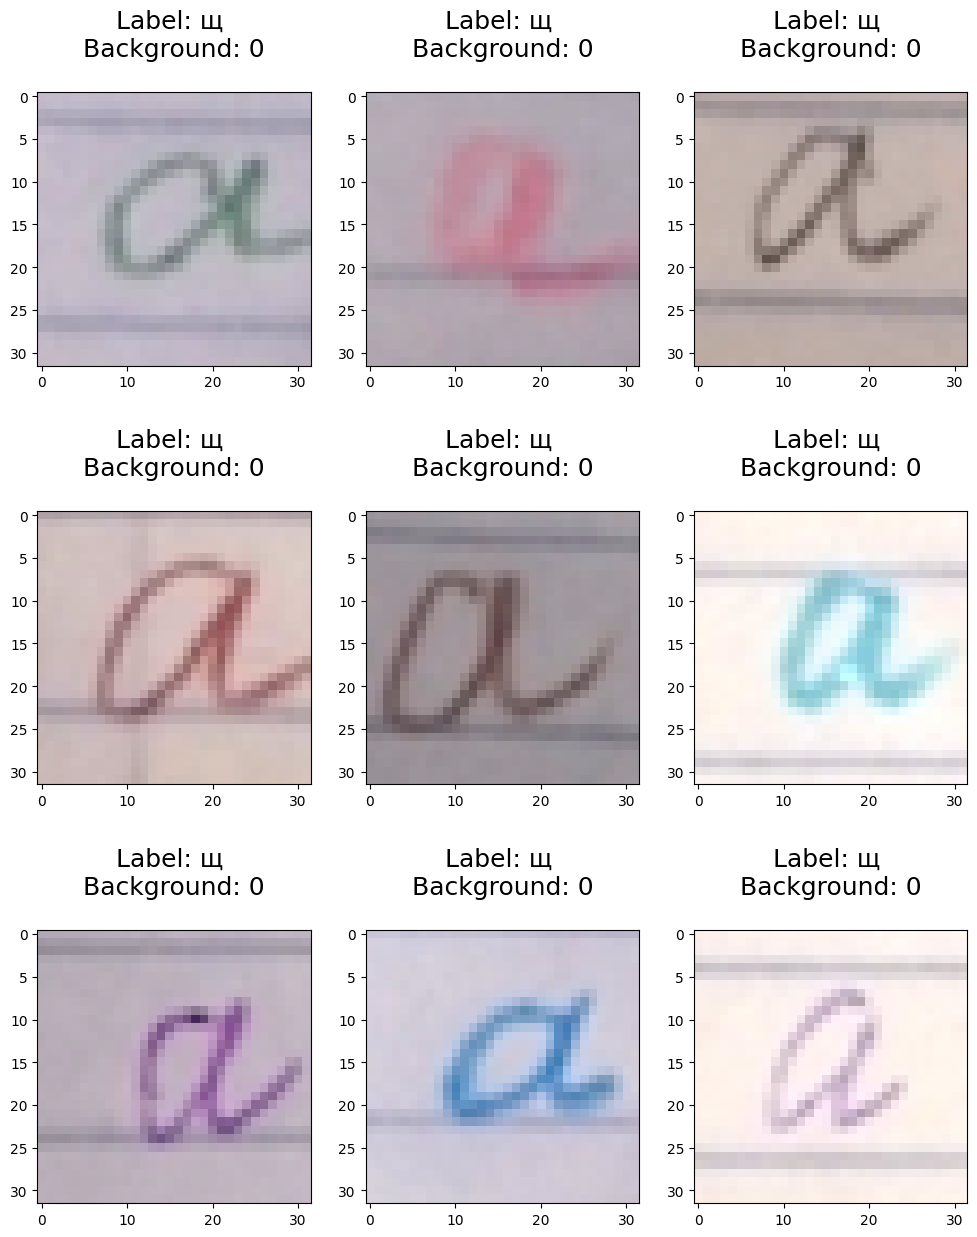

In [25]:
display_image(images)

In [26]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)

We're all set and the data are ready to feed the model. Let's create the model now.

In [27]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 10

In [28]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [29]:
def CNN_model(activation = 'softmax',
              loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', top_3_categorical_accuracy]):

    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))

    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    return model

In [33]:
# Init CNN model
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.h5',
                               verbose = 2,
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=2,
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0354 - loss: 3.4931 - top_3_categorical_accuracy: 0.1062
Epoch 1: val_loss improved from inf to 3.08704, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.0354 - loss: 3.4929 - top_3_categorical_accuracy: 0.1064 - val_accuracy: 0.1765 - val_loss: 3.0870 - val_top_3_categorical_accuracy: 0.3686 - learning_rate: 0.0010
Epoch 2/10
175/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1915 - loss: 2.9005 - top_3_categorical_accuracy: 0.3923
Epoch 2: val_loss improved from 3.08704 to 2.23997, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1925 - loss: 2.8965 - top_3_categorical_accuracy: 0.3937 - val_accuracy: 0.3844 - val_loss: 2.2400 - val_top_3_categorical_accuracy: 0.6159 - learning_rate: 0.0010
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3509 - loss: 2.2546 - top_3_categorical_accuracy: 0.5981
Epoch 3: val_loss improved from 2.23997 to 1.93158, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3510 - loss: 2.2543 - top_3_categorical_accuracy: 0.5982 - val_accuracy: 0.4637 - val_loss: 1.9316 - val_top_3_categorical_accuracy: 0.6952 - learning_rate: 0.0010
Epoch 4/10
173/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4385 - loss: 1.9225 - top_3_categorical_accuracy: 0.6836
Epoch 4: val_loss improved from 1.93158 to 1.54840, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4392 - loss: 1.9205 - top_3_categorical_accuracy: 0.6841 - val_accuracy: 0.5701 - val_loss: 1.5484 - val_top_3_categorical_accuracy: 0.7706 - learning_rate: 0.0010
Epoch 5/10
175/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5176 - loss: 1.6368 - top_3_categorical_accuracy: 0.7509
Epoch 5: val_loss improved from 1.54840 to 1.30840, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5180 - loss: 1.6357 - top_3_categorical_accuracy: 0.7512 - val_accuracy: 0.6279 - val_loss: 1.3084 - val_top_3_categorical_accuracy: 0.8199 - learning_rate: 0.0010
Epoch 6/10
176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5910 - loss: 1.4013 - top_3_categorical_accuracy: 0.7944
Epoch 6: val_loss improved from 1.30840 to 1.12183, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5911 - loss: 1.4008 - top_3_categorical_accuracy: 0.7945 - val_accuracy: 0.6899 - val_loss: 1.1218 - val_top_3_categorical_accuracy: 0.8629 - learning_rate: 0.0010
Epoch 7/10
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6406 - loss: 1.2143 - top_3_categorical_accuracy: 0.8412
Epoch 7: val_loss improved from 1.12183 to 0.95747, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6407 - loss: 1.2141 - top_3_categorical_accuracy: 0.8412 - val_accuracy: 0.7361 - val_loss: 0.9575 - val_top_3_categorical_accuracy: 0.8894 - learning_rate: 0.0010
Epoch 8/10
174/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6810 - loss: 1.0674 - top_3_categorical_accuracy: 0.8677
Epoch 8: val_loss improved from 0.95747 to 0.88987, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6810 - loss: 1.0676 - top_3_categorical_accuracy: 0.8677 - val_accuracy: 0.7424 - val_loss: 0.8899 - val_top_3_categorical_accuracy: 0.8901 - learning_rate: 0.0010
Epoch 9/10
173/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7010 - loss: 0.9736 - top_3_categorical_accuracy: 0.8766
Epoch 9: val_loss improved from 0.88987 to 0.86689, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7011 - loss: 0.9737 - top_3_categorical_accuracy: 0.8766 - val_accuracy: 0.7551 - val_loss: 0.8669 - val_top_3_categorical_accuracy: 0.9013 - learning_rate: 0.0010
Epoch 10/10
176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7264 - loss: 0.8962 - top_3_categorical_accuracy: 0.8973
Epoch 10: val_loss improved from 0.86689 to 0.76280, saving model to weights.best.letters.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7264 - loss: 0.8961 - top_3_categorical_accuracy: 0.8973 - val_accuracy: 0.7875 - val_loss: 0.7628 - val_top_3_categorical_accuracy: 0.9172 - learning_rate: 0.0010


In [34]:
# loading the model with the best validation accuracy
cnn_model.load_weights('weights.best.letters.h5')
cnn_model.evaluate(X_val, y_val)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7914 - loss: 0.7316 - top_3_categorical_accuracy: 0.9233


[0.7628012895584106, 0.7875264286994934, 0.917195200920105]

In [35]:
def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [36]:
def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

In [37]:
img = load_image(PATH_TO_DATA+'letters3/01_235.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
true label: а


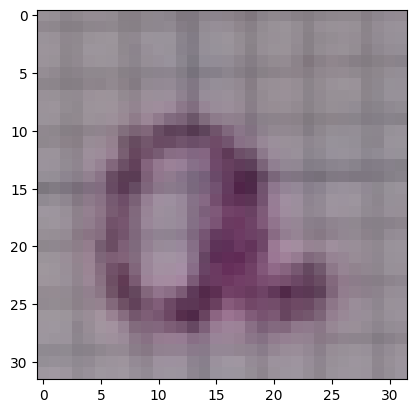

In [38]:
# predict the class
a_letter = cnn_model.predict(img)

plt.imshow(img[0])
print('true label:', get_true_label(PATH_TO_DATA+'letters3/01_235.png', data, 'letter'))

In [39]:
def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []

    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))

        index_image = random.randint(0, len(os.listdir(path)))

        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)

    return images, true_labels, true_backgrounds

In [40]:
def classes_predictions(images_list_to_classify, true_labels, model):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):

        #a_letter = model.predict(image)
        #letter_arr = np.array([a_letter])
        #associated_letter = letters[int(letter_arr[0])]

        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)

    # show the figure
    plt.show()

In [41]:
test_images, true_labels, true_backgrounds = load_random_images()

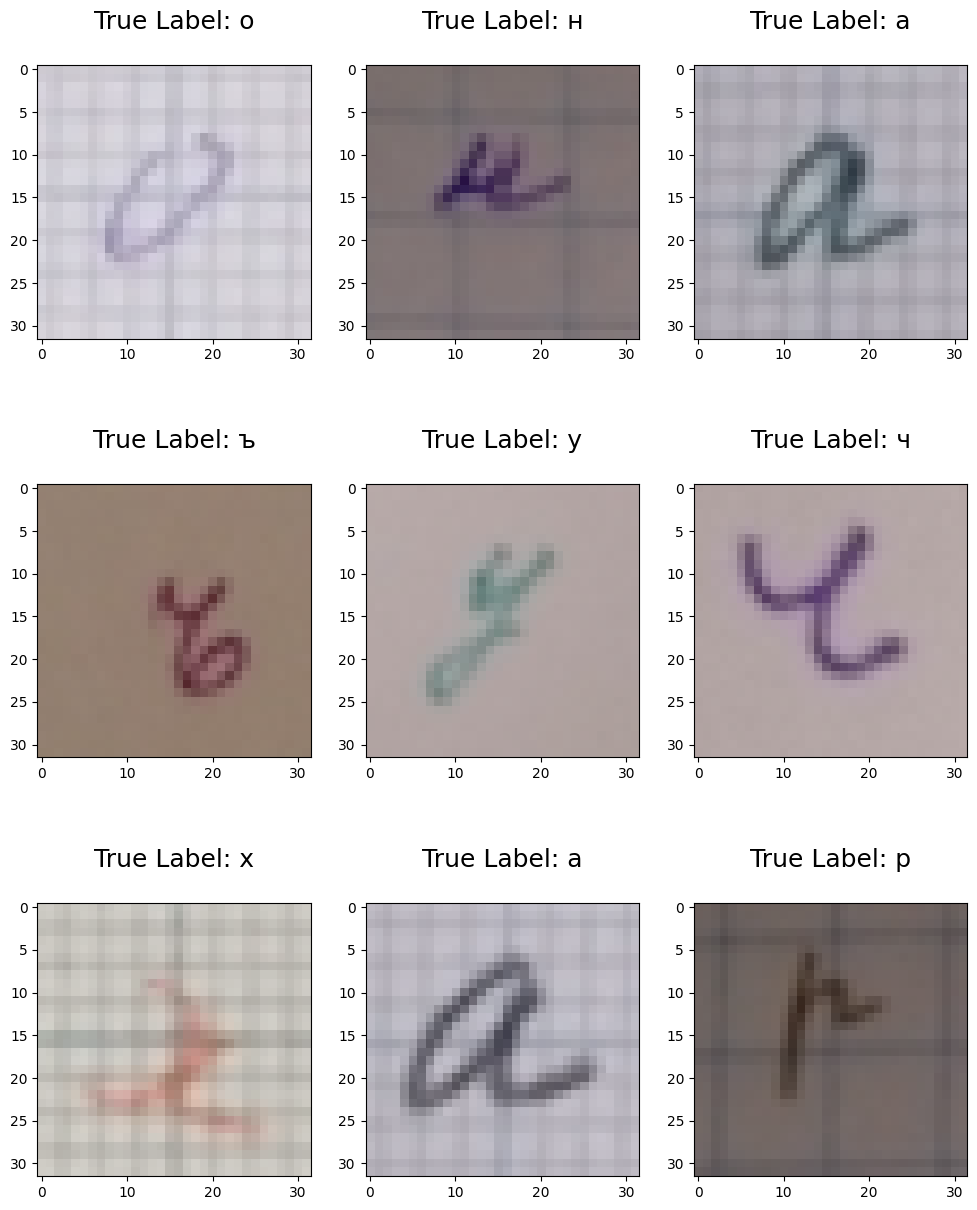

In [42]:
classes_predictions(test_images, true_labels, cnn_model)